In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import clone
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:

# Define your target dataset path
target_dir = '../../balanced_dataset'

# Check if the path exists
if os.path.exists(target_dir):
    print(f"The dataset path {target_dir} exists.")
else:
    print(f"The dataset path {target_dir} does not exist.")

The dataset path ../../balanced_dataset exists.


In [3]:
classes = ['home_office', 'hotel_room', 'church', 'museum', 'supermarket']

def show_target_dir_status(target_dir, classes):
    """
    Show the number of images in each class directory within the target directory.

    """
    print(f"Status of target directory: {target_dir}")
    for cls in classes:
        class_dir = os.path.join(target_dir, cls)
        if os.path.exists(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"Class '{cls}' contains {num_images} images.")
        else:
            print(f"Class directory '{cls}' does not exist.")

# Show the status of the target directory
show_target_dir_status(target_dir, classes)

Status of target directory: ../../balanced_dataset
Class 'home_office' contains 700 images.
Class 'hotel_room' contains 700 images.
Class 'church' contains 700 images.
Class 'museum' contains 700 images.
Class 'supermarket' contains 700 images.


In [4]:
# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load the dataset
# dataset = datasets.ImageFolder(target_dir, transform=transform)

# # Print the mapping of class indices to class names
# print("Class to index mapping:", dataset.class_to_idx)


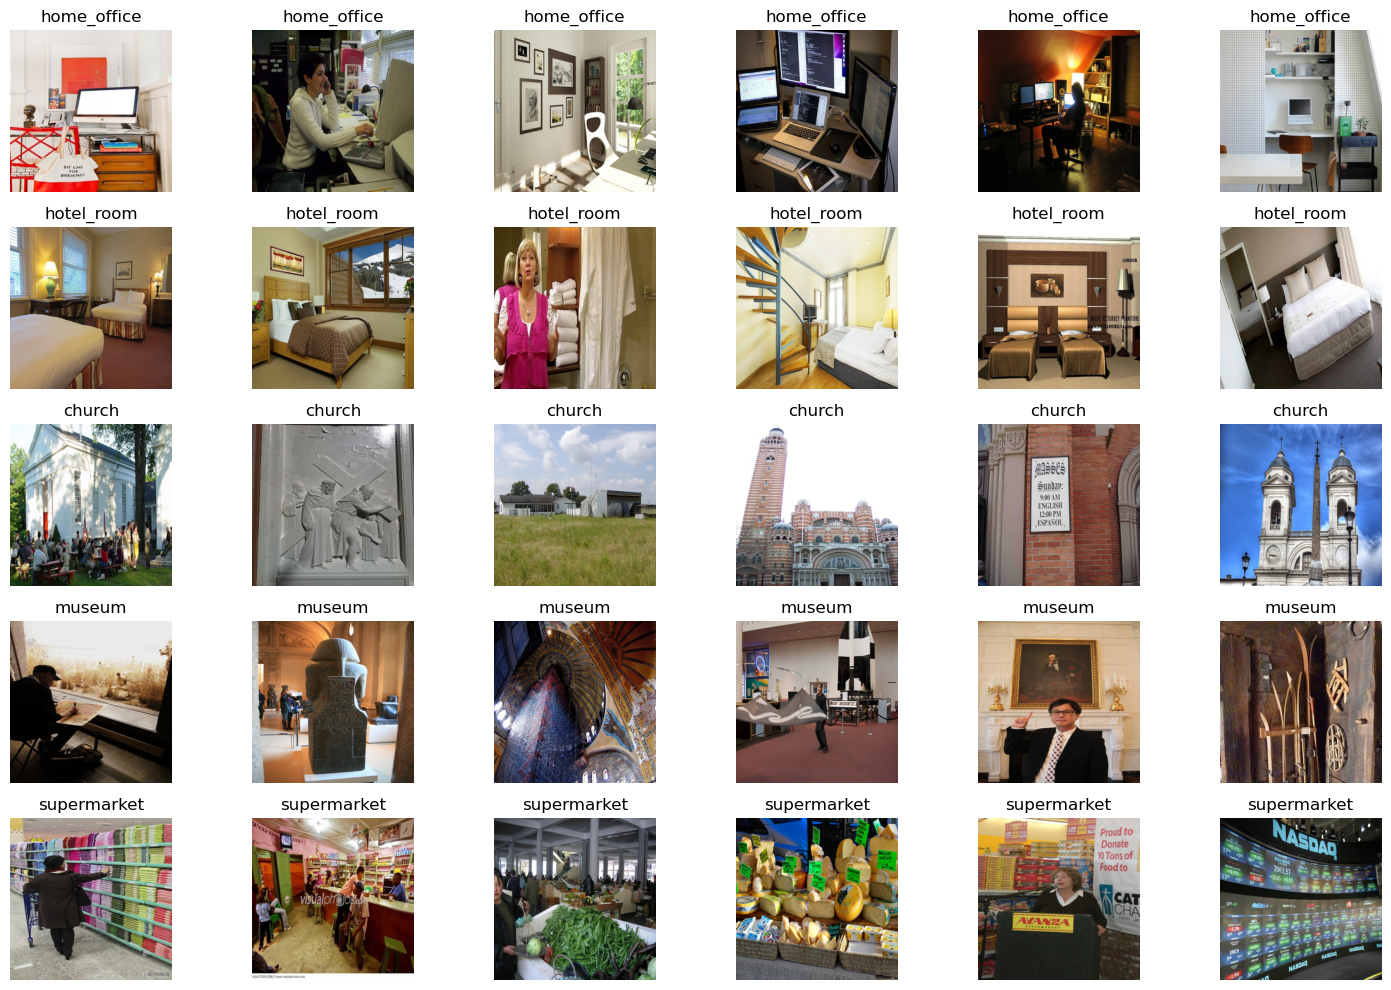

In [5]:
def show_images_with_labels(target_dir, classes, num_images=6):
    """
    Display images with their corresponding labels from the target directory.

    """
    # Create figure and axes
    fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 10))
    
    # Iterate through each class
    for i, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        class_images = os.listdir(class_dir)
        selected_images = np.random.choice(class_images, num_images, replace=False)
        
        # Iterate through selected images for the class
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            
            # Plot the image
            axes[i, j].imshow(img)
            axes[i, j].set_title(cls)
            axes[i, j].axis('off')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

show_images_with_labels(target_dir, classes)

In [6]:
def is_image_file(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

def preprocess_images(target_dir, classes, image_size=(256, 256)):
    X = []
    y = []
    
    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')  # Ensure image is in RGB mode
                        img = img.resize(image_size)  # Resize image
                        img_array = np.array(img).flatten()  # Flatten the image
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    return X, y

# Preprocess labeled images
X_labeled, y_labeled = preprocess_images(target_dir, classes)
print("Labeled image data shape:", X_labeled.shape)
print("Labeled labels shape:", y_labeled.shape)

Labeled image data shape: (3499, 196608)
Labeled labels shape: (3499,)


In [7]:
# Split the labeled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (2799, 196608)
Testing data shape: (700, 196608)


In [8]:
# Assume a portion of the training data is unlabeled for the purpose of semi-supervised learning
X_train_labeled, X_train_unlabeled, y_train_labeled, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_labeled_normalized = scaler.fit_transform(X_train_labeled)
X_train_unlabeled_normalized = scaler.transform(X_train_unlabeled)
X_test_normalized = scaler.transform(X_test)

In [9]:
from sklearn.semi_supervised import SelfTrainingClassifier

def self_training(clf, X_train, y_train, X_unlabeled, max_iter=12, confidence_threshold=0.2):
    """
    使用 SelfTrainingClassifier 的自训练算法进行半监督学习。

    参数:
    - clf: 用于训练的分类器
    - X_train: 有标签的训练数据
    - y_train: 训练数据的标签
    - X_unlabeled: 无标签的数据
    - max_iter: 自训练的最大迭代次数
    - confidence_threshold: 添加预测标签到训练数据的最小置信度阈值

    返回:
    - clf: 训练后的分类器
    """
    base_clf = clone(clf)  # 克隆分类器以避免修改原始模型
    self_training_clf = SelfTrainingClassifier(base_clf, criterion='threshold', threshold=confidence_threshold, max_iter=max_iter)
    X_full_train = np.vstack([X_train, X_unlabeled])
    y_full_train = np.concatenate([y_train, [-1] * len(X_unlabeled)])  # 用 -1 标记无标签数据
    
    self_training_clf.fit(X_full_train, y_full_train)
    return self_training_clf

# 初始化基础分类器
base_clf = DecisionTreeClassifier(random_state=42)
# 进行自训练
self_training_clf = self_training(base_clf, X_train_labeled_normalized, y_train_labeled, X_train_unlabeled_normalized)

# 在测试集上进行预测
y_pred = self_training_clf.predict(X_test_normalized)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
print("Semi-supervised Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))

Semi-supervised Accuracy: 0.2642857142857143
Classification Report:
               precision    recall  f1-score   support

 home_office       0.18      0.17      0.18       140
  hotel_room       0.24      0.22      0.23       140
      church       0.41      0.46      0.43       140
      museum       0.24      0.28      0.26       140
 supermarket       0.23      0.19      0.21       140

    accuracy                           0.26       700
   macro avg       0.26      0.26      0.26       700
weighted avg       0.26      0.26      0.26       700

